<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/2_CNN_Multivariate_Horizon_Style_FlowData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
#                infer_datetime_format=True)
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)

In [3]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [4]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [5]:
#df.drop_duplicates(subset=['Processing_time'], keep=False,inplace=True)

In [6]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [7]:
df = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

In [8]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [9]:
validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(100)
df.drop(df.tail(100).index,inplace=True)

In [10]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataY = y_scaler.fit_transform(df[['total_data_bytes']])

In [11]:
#hist_window = 12
#horizon = 10
hist_window = 100
horizon = 100

TRAIN_SPLIT = 5574
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [12]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.00318907 1.         1.         ... 0.92620063 0.83064738 0.53022238]
 [0.00501139 1.         1.         ... 0.5560866  0.51308245 0.95353474]
 [0.00592255 1.         1.         ... 0.54369195 0.65795782 0.94257725]
 ...
 [0.00318907 1.         1.         ... 0.61981821 0.69114817 0.95200497]
 [0.00364465 1.         1.         ... 0.46506693 0.51369613 0.95334139]
 [0.00273349 1.         1.         ... 0.44040985 0.45972346 0.55709518]]

 Target horizon
[[0.95675579]
 [0.95342669]
 [0.96434892]
 [0.93700524]
 [0.95319011]
 [0.97162017]
 [0.96217198]
 [0.95016128]
 [0.9435008 ]
 [0.5483135 ]
 [0.95733813]
 [0.96416353]
 [0.94840972]
 [0.95597214]
 [0.94372373]
 [0.94332451]
 [0.94130339]
 [0.93501483]
 [0.95018971]
 [0.9423566 ]
 [0.96352546]
 [0.54706807]
 [0.95907149]
 [0.94840176]
 [0.94293666]
 [0.96204914]
 [0.96224591]
 [0.9554262 ]
 [0.94530809]
 [0.94497712]
 [0.9765598 ]
 [0.97429869]
 [0.54664269]
 [0.95076864]
 [0.96023048]
 [0.94912172]
 [0.9

In [13]:
#BATCH_SIZE = 256
#BUFFER_SIZE = 150
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [14]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_multi.shape[1], x_train_multi.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

In [15]:
model_path = r'CNN_Multivariate.h5'

In [16]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 6s 53ms/step - loss: 0.5271 - val_loss: 0.0268
Epoch 2/150
100/100 [==============================] - 5s 48ms/step - loss: 0.1021 - val_loss: 0.0166
Epoch 3/150
100/100 [==============================] - 5s 47ms/step - loss: 0.0714 - val_loss: 0.0103
Epoch 4/150
100/100 [==============================] - 5s 47ms/step - loss: 0.0516 - val_loss: 0.0160
Epoch 5/150
100/100 [==============================] - 5s 48ms/step - loss: 0.0480 - val_loss: 0.0123
Epoch 6/150
100/100 [==============================] - 5s 48ms/step - loss: 0.0391 - val_loss: 0.0108
Epoch 7/150
100/100 [==============================] - 5s 47ms/step - loss: 0.0372 - val_loss: 0.0101
Epoch 8/150
100/100 [==============================] - 5s 47ms/step - loss: 0.0334 - val_loss: 0.0099
Epoch 9/150
100/100 [==============================] - 5s 47ms/step - loss: 0.0325 - val_loss: 0.0126
Epoch 10/150
100/100 [==============================] - 5s 47ms/step - loss: 0.031

In [17]:
Trained_model = tf.keras.models.load_model(model_path)

In [18]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 64)            2368      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                94110     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3

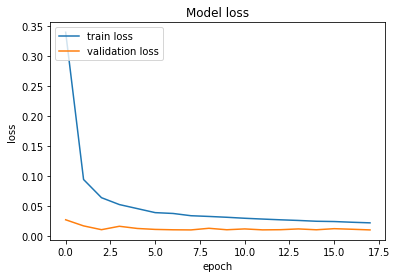

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [20]:
data_val = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100))

In [21]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [22]:
Predicted_results = Trained_model.predict(val_rescaled)

In [23]:
Predicted_results

array([[0.8104872 , 0.7987435 , 0.7844188 , 0.79134256, 0.7612312 ,
        0.78531784, 0.84533405, 0.7912759 , 0.80873054, 0.7692263 ,
        0.78531146, 0.78610265, 0.81465423, 0.79097986, 0.80041677,
        0.7965322 , 0.77218616, 0.78626645, 0.80777526, 0.8097847 ,
        0.7423421 , 0.78892994, 0.793686  , 0.7995582 , 0.78506994,
        0.7551703 , 0.79547465, 0.79022527, 0.78242326, 0.8158071 ,
        0.7748876 , 0.80118287, 0.7746052 , 0.76201415, 0.7758619 ,
        0.78982794, 0.7844153 , 0.7831704 , 0.77907586, 0.8048126 ,
        0.7929342 , 0.793425  , 0.8349695 , 0.78157604, 0.74378777,
        0.82422936, 0.77556777, 0.7946909 , 0.7603178 , 0.7830549 ,
        0.75486875, 0.78602874, 0.7732584 , 0.7859325 , 0.7819971 ,
        0.7779107 , 0.79623526, 0.7928823 , 0.7714048 , 0.77505296,
        0.7809898 , 0.7877897 , 0.814889  , 0.7716285 , 0.8220782 ,
        0.78972447, 0.78234357, 0.79241234, 0.77878857, 0.80418503,
        0.80474716, 0.8001542 , 0.8096601 , 0.81

In [24]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [25]:
Predicted_results_Inv_trans

array([[756665.3 , 746340.06, 733745.56, 739833.06, 713358.6 , 734536.  ,
        787303.25, 739774.44, 755120.9 , 720388.1 , 734530.44, 735226.06,
        760329.06, 739514.2 , 747811.25, 744395.9 , 722990.44, 735370.06,
        754280.94, 756047.7 , 696751.06, 737711.8 , 741893.44, 747056.4 ,
        734318.06, 708029.8 , 743466.06, 738850.7 , 731991.06, 761342.7 ,
        725365.6 , 748484.8 , 725117.3 , 714047.06, 726222.25, 738501.4 ,
        733742.5 , 732647.94, 729048.  , 751676.1 , 741232.44, 741664.  ,
        778190.56, 731246.2 , 698022.1 , 768747.6 , 725963.6 , 742777.  ,
        712555.56, 732546.4 , 707764.7 , 735161.06, 723933.2 , 735076.44,
        731616.4 , 728023.56, 744134.8 , 741186.8 , 722303.44, 725511.  ,
        730730.75, 736709.3 , 760535.5 , 722500.1 , 766856.4 , 738410.4 ,
        731921.  , 740773.6 , 728795.4 , 751124.4 , 751618.6 , 747580.4 ,
        755938.1 , 759128.  , 732575.06, 723190.9 , 704689.2 , 728304.4 ,
        739335.75, 740167.94, 733216.4

In [26]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [27]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 8197022655.139688
MAE is : 47064.97875
RMSE is : 90537.41025200405
MAPE is : 8.551240897222423
R2 is : -0.05541060659646635



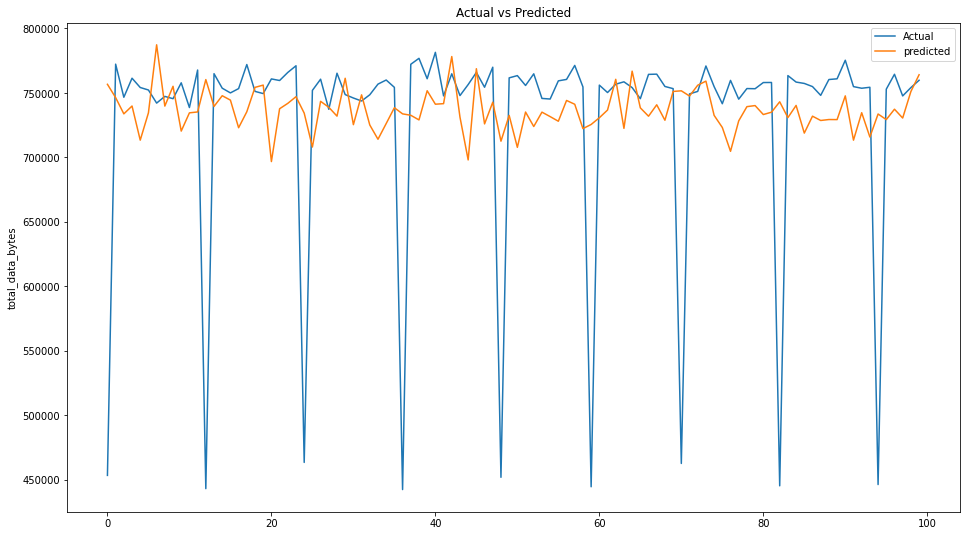

In [28]:


plt.plot( list(validate['total_data_bytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("total_data_bytes")
plt.legend(('Actual','predicted'))
plt.show()
